# Event Impact Analysis

Analyze the impact of key market events on Bitcoin returns using event windows.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

project_root = Path('..')

# Load data
prices_csv = project_root / 'data' / 'raw' / 'bitcoin_prices.csv'
with open(prices_csv, 'r', encoding='utf-8') as f:
    line1 = f.readline().strip(); f.readline(); f.readline()
columns = ['Date'] + [h.strip().strip('"') for h in line1.split(',')]
prices = pd.read_csv(prices_csv, skiprows=3, header=None, names=columns)
prices['Date'] = pd.to_datetime(prices['Date'], errors='coerce')
prices = prices.dropna(subset=['Date']).set_index('Date').sort_index()

for c in prices.columns:
    if c != 'Ticker' and prices[c].dtype == 'object':
        prices[c] = pd.to_numeric(prices[c], errors='coerce')

# Returns
if 'Close' in prices.columns:
    prices['ret'] = prices['Close'].pct_change()
else:
    prices['ret'] = prices['Price'].pct_change() if 'Price' in prices.columns else np.nan

# Events
events_csv = project_root / 'data' / 'processed' / 'market_events.csv'
events = pd.read_csv(events_csv, parse_dates=['date'])

prices.head(), events.head()


(                  Price    Adj Close        Close         High          Low  \
 Date                                                                          
 2020-01-31  9350.529297  9350.529297  9521.706055  9230.776367  9508.313477   
 2020-02-01  9392.875000  9392.875000  9439.323242  9313.239258  9346.357422   
 2020-02-02  9344.365234  9344.365234  9468.797852  9217.824219  9389.820312   
 2020-02-03  9293.521484  9293.521484  9540.372070  9248.633789  9344.683594   
 2020-02-04  9180.962891  9180.962891  9331.265625  9112.811523  9292.841797   
 
                    Open    Volume  Daily_Return  Volatility_30d  Abs_Return  \
 Date                                                                          
 2020-01-31  29432489719 -0.016665      0.028623        0.016665         NaN   
 2020-02-01  25922656496  0.004529      0.027682        0.004529         NaN   
 2020-02-02  30835736946 -0.005165      0.026691        0.005165         NaN   
 2020-02-03  30934096509 -0.005441    

In [2]:
# Define event window function
from dataclasses import dataclass
from typing import Tuple

@dataclass
class EventWindowParams:
    pre_days: int = 3
    post_days: int = 3


def compute_event_window_returns(prices: pd.DataFrame, events: pd.DataFrame, date_col: str = 'date', ret_col: str = 'ret', params: EventWindowParams = EventWindowParams()) -> pd.DataFrame:
    out = []
    for _, row in events.iterrows():
        d = pd.to_datetime(row[date_col])
        window = prices.loc[d - pd.Timedelta(days=params.pre_days): d + pd.Timedelta(days=params.post_days)]
        window = window[[ret_col]].rename(columns={ret_col: 'ret'})
        window = window.assign(event_date=d)
        out.append(window)
    return pd.concat(out).reset_index(names='date')

window_returns = compute_event_window_returns(prices, events)
window_returns.head()


,date,ret,event_date
0,2020-03-09,-0.082625,2020-03-12
1,2020-03-10,-0.004995,2020-03-12
2,2020-03-11,-0.022875,2020-03-12
3,2020-03-12,-0.002729,2020-03-12
4,2020-03-13,-0.263712,2020-03-12


In [3]:
# Aggregate by relative day around event
window_returns['rel_day'] = (window_returns['date'] - window_returns['event_date']).dt.days
agg = window_returns.groupby(['event_date', 'rel_day'])['ret'].mean().reset_index()
agg.head()


,event_date,rel_day,ret
0,2020-03-12,-3,-0.082625
1,2020-03-12,-2,-0.004995
2,2020-03-12,-1,-0.022875
3,2020-03-12,0,-0.002729
4,2020-03-12,1,-0.263712


Text(0, 0.5, 'Average daily return')

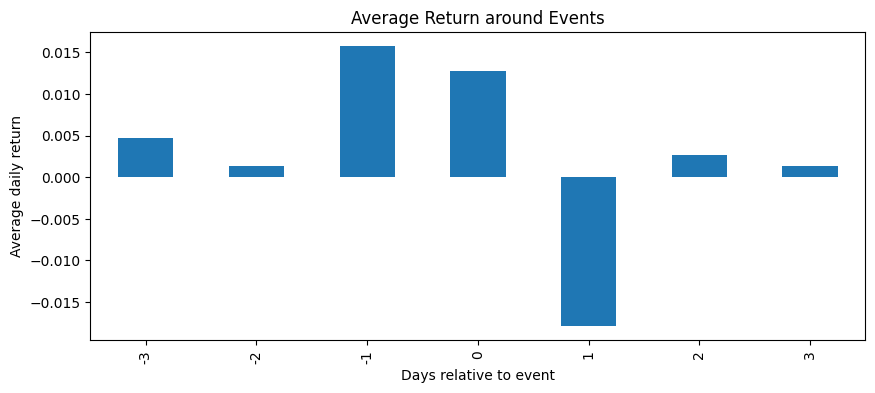

In [4]:
# Plot average returns by relative day
avg_by_rel = window_returns.groupby('rel_day')['ret'].mean()
ax = avg_by_rel.plot(kind='bar', figsize=(10,4), title='Average Return around Events')
ax.set_xlabel('Days relative to event')
ax.set_ylabel('Average daily return')
